In [50]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load and prepare data

Load the data

In [51]:
df=pd.read_csv('https://covidtracking.com/api/v1/states/daily.csv')

Reverse the order of the data, some plottings will go better if the oldest dates are on top of the dataframe.

In [52]:
df=df.iloc[::-1]

Also, stripping out the year and turning the date into a string will simplify plotting.

In [53]:
df['Date']=df['date'].astype(str).str[5:]
df['DateTime']=pd.to_datetime(df['date'], format='%Y%m%d')

# Question 1:  How many states?

How many different "states" are there?

In [54]:
print(np.unique(df['state']))
print('There are %d unique state entries, must be including territories.'%len(np.unique(df['state'])))

['AK' 'AL' 'AR' 'AS' 'AZ' 'CA' 'CO' 'CT' 'DC' 'DE' 'FL' 'GA' 'GU' 'HI'
 'IA' 'ID' 'IL' 'IN' 'KS' 'KY' 'LA' 'MA' 'MD' 'ME' 'MI' 'MN' 'MO' 'MP'
 'MS' 'MT' 'NC' 'ND' 'NE' 'NH' 'NJ' 'NM' 'NV' 'NY' 'OH' 'OK' 'OR' 'PA'
 'PR' 'RI' 'SC' 'SD' 'TN' 'TX' 'UT' 'VA' 'VI' 'VT' 'WA' 'WI' 'WV' 'WY']
There are 56 unique state entries, must be including territories.


# Question 2: Which 5 states have highest positive testing rate?

First we will make a new dataframe that has just the states, positives, negatives, and the positive fraction.

In [55]:
posneg=df.groupby(['state']).aggregate({'positive':np.max, 'negative':np.max}).reset_index()
posneg['PositiveRatio']=posneg['positive']/(posneg['positive']+posneg['negative'])
posneg.head()

,state,positive,negative,PositiveRatio
0,AK,792.0,95304.0,0.008242
1,AL,32064.0,326695.0,0.089375
2,AR,17375.0,254491.0,0.063910
3,AS,0.0,174.0,0.000000
4,AZ,59974.0,389214.0,0.133516


Now find the 5 highest ratios.

In [56]:
posneg.sort_values(by='PositiveRatio', ascending=False)[0:5][['state', 'PositiveRatio']]

,state,PositiveRatio
42,PR,0.422736
21,MA,0.135347
4,AZ,0.133516
22,MD,0.133217
34,NJ,0.130722


# Question 3:  Plot daily death toll for whole country

Let's plot daily death toll for the whole country.

Text(0.5, 1.0, 'US Daily Death Toll')

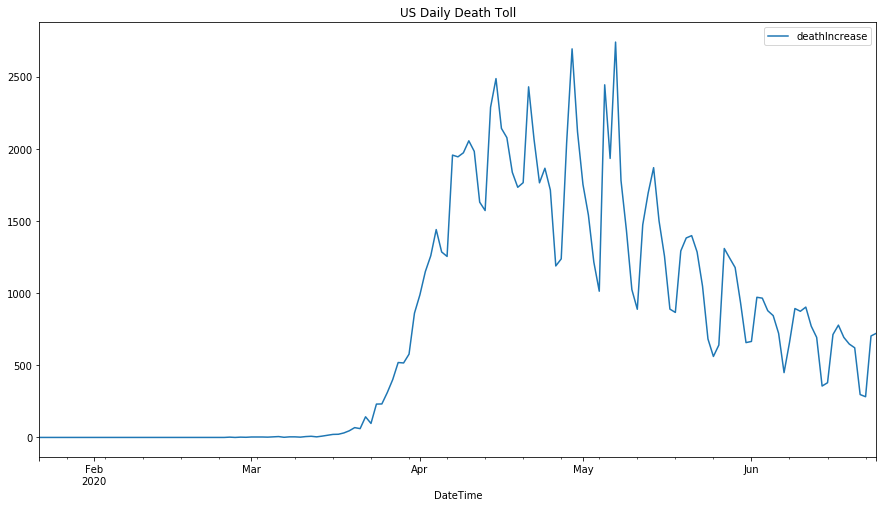

In [57]:
df.groupby('DateTime').aggregate({'deathIncrease':np.sum}).plot(figsize=[15,8])
plt.title('US Daily Death Toll')

# Question 4:  Plot daily death toll for just Kansas and Missouri

Now let's focus on Missouri and Kansas, first we will graph their combined totals.

Text(0.5, 1.0, 'Missouri + Kansas Daily Death Toll')

<Figure size 1080x576 with 0 Axes>

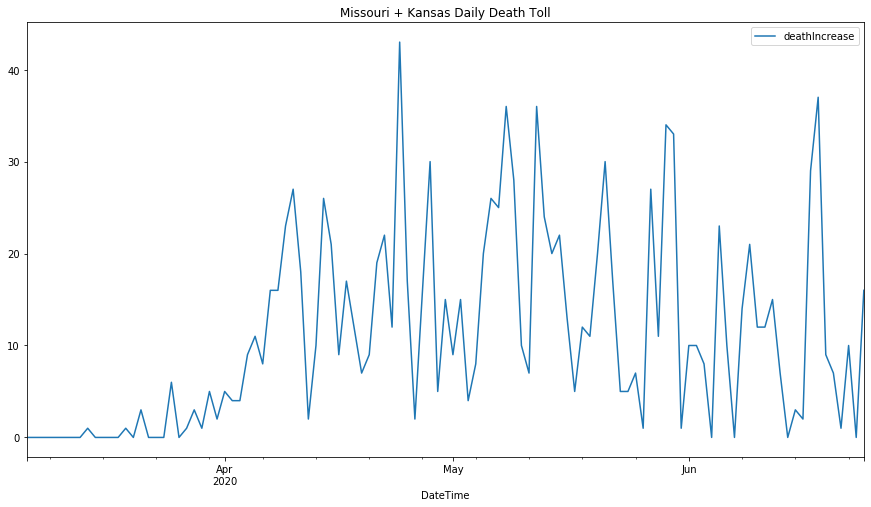

In [58]:
plt.figure(figsize=[15,8])
df[df['state'].isin(['MO', 'KS'])].groupby('DateTime').aggregate({'deathIncrease':np.sum}).plot(figsize=[15,8])
plt.title('Missouri + Kansas Daily Death Toll')

Now let's separate them out.

Text(0.5, 1.0, 'Missouri and Kansas Daily Death Toll')

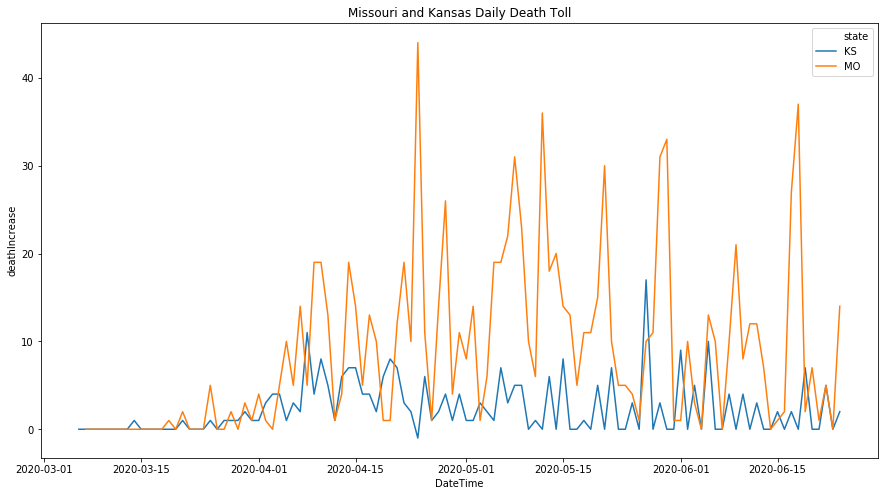

In [59]:
plt.figure(figsize=[15,8])
sns.lineplot(data=df[df['state'].isin(['MO', 'KS'])], x='DateTime', y='deathIncrease', hue='state')
plt.title('Missouri and Kansas Daily Death Toll')

# Question 5:  Plot the daily testing rate for Kansas and Missouri

What is the daily testing rate looking like for Kansas and Missouri?

Text(0.5, 1.0, 'Missouri + Kansas Daily Testings')

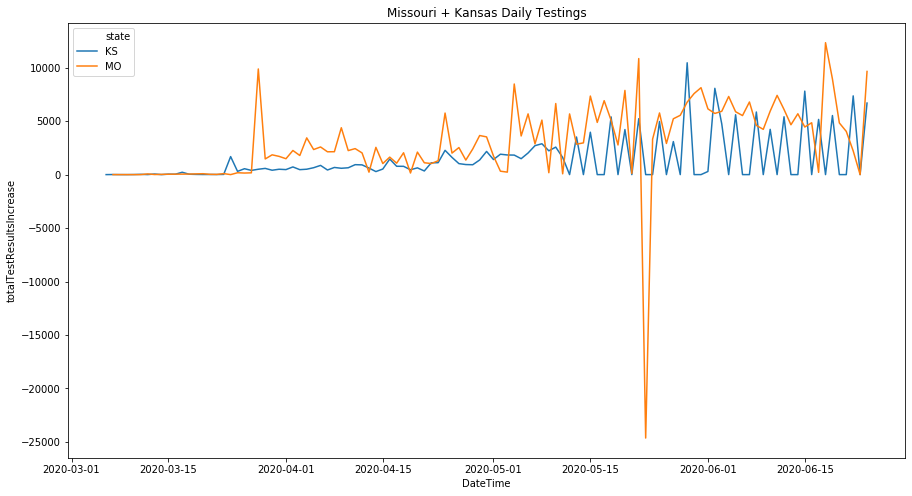

In [60]:
plt.figure(figsize=[15,8])
sns.lineplot(data=df[df['state'].isin(['MO', 'KS'])], x='DateTime', y='totalTestResultsIncrease', hue='state')
plt.title('Missouri + Kansas Daily Testings')

# Question 6:  Make a table of peak testing day for each state

In [61]:
df.groupby(['state']).apply(lambda x: 
                            x.iloc[np.argmax(x['totalTestResultsIncrease'])]
                           ).sort_values(by='DateTime')[['totalTestResultsIncrease','DateTime']]

,totalTestResultsIncrease,DateTime
state,,
PR,630,2020-04-04
UT,6093,2020-04-17
CA,165227,2020-04-22
AL,18649,2020-04-25
WV,6097,2020-04-26
ID,8330,2020-04-29
AS,54,2020-05-01
GU,897,2020-05-01
MA,15652,2020-05-03


# Question 8:  What is the peak death day for the whole country?

In [62]:
agged_df=df.groupby(['DateTime']).aggregate({'deathIncrease':np.sum}).reset_index()
agged_df.loc[np.argmax(agged_df['deathIncrease'])]

DateTime         2020-05-07 00:00:00
deathIncrease                   2739
Name: 106, dtype: object

So far it is April 21, on which 2674 died.

# Challenge:  Plot the per capita testing fraction in descending order

First let's make a new dataframe that simply aggregates the total tests per state.

In [63]:
tests_agged=df.groupby(['state']).agg({'totalTestResultsIncrease':np.sum}).reset_index()

Now let's read in the population data, and keep only the parts we want.

In [64]:
pop=pd.read_csv('http://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv', usecols=['NAME', 'CENSUS2010POP'])

Now the problem is that our tests_agged has state abbreviations and our pop dataframe has full state names.  We need to convert one to the other before we can merge.

First let's load a file that has both.

In [65]:
abb=pd.read_csv('http://www.fonz.net/blog/wp-content/uploads/2008/04/states.csv')

Then we will make a dictionary that takes abbreviations and turns them into the full state names.

In [66]:
mapper={a:b for a,b in zip(abb['Abbreviation'], abb['State'])}

Now that we have a dictionary, we can create a new column in tests_agged and use .map to generate it.

In [67]:
tests_agged['StateNames']=tests_agged['state'].map(mapper)

Now we can merge the tests_agged and pop dataframes because they both have a column with the full state name in them.

In [68]:
tests_agged=tests_agged.merge(pop, left_on='StateNames', right_on='NAME')

Calculate the per 1000 tests, add to a column

In [69]:
tests_agged['PerThousand']=tests_agged['totalTestResultsIncrease']/tests_agged['CENSUS2010POP']*1000

Sort, show the top 5.

In [70]:
tests_agged.sort_values(by='PerThousand', ascending=False)[0:5].loc[:,['NAME', 'PerThousand']]

,NAME,PerThousand
39,Rhode Island,213.755514
34,New York,183.294422
31,New Jersey,147.822983
28,North Dakota,146.729588
32,New Mexico,146.692930


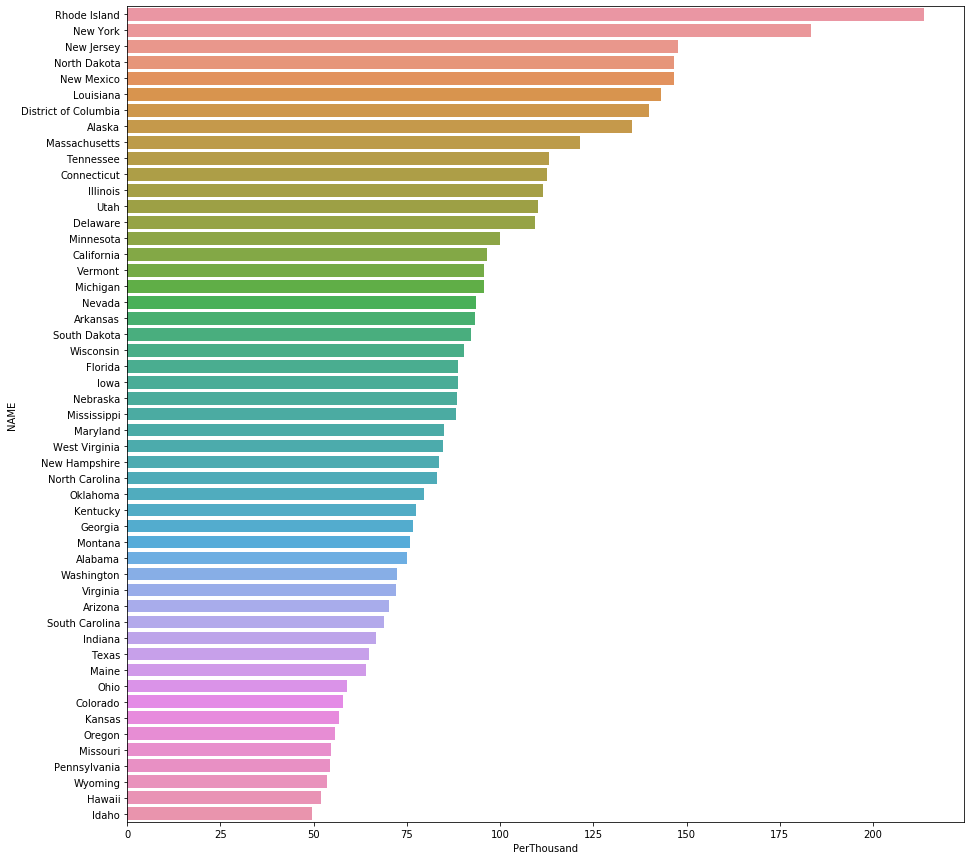

In [71]:
plt.figure(figsize=[15,15])
sns.barplot(data=tests_agged.sort_values(by='PerThousand', ascending=False), x='PerThousand', y='NAME')